A large travel agency has asked us to predict whether a flight will be canceled based on several factors. The agency can sell tickets for only three airlines (AA, UA, and DL) and would like to be able to advise its customers on which airline has the least risk of cancellation. Using the dataset provided:
1. Build a model to predict whether a flight will be canceled.
2. Write your own function that uses the model output to predict whether a future flight will be canceled.
3. Provide fully commented code and model output for your analysis.
4. Provide a recommendation on which airline is most reliable.

Auther: Feiyi Wang 
Date: October 23, 2017

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('Data_PredictingFlightDelays.csv',header=None)

## Data Exploration

In [4]:
data.head(3)

,0,1,2,3,4,5,6,7
0,1,12,814,UA,134,0,0,679
1,1,12,830,DL,90,0,0,214
2,1,1,1835,UA,213,0,0,1605


In [5]:
# Rename col names regarding to the direction file
data.columns = ['canceled','month','departureTime','uniqueCarrier','schedElapsedTime','arrDelay','depDelay','distance']

In [5]:
# Check if there are any null values
data.isnull().sum().sort_values()

canceled            0
month               0
departureTime       0
uniqueCarrier       0
schedElapsedTime    0
arrDelay            0
depDelay            0
distance            0
dtype: int64

In [6]:
# Check the unique values in the only categorical variable
data.uniqueCarrier.unique()

array(['UA', 'DL', 'AA'], dtype=object)

In [773]:
# Convert the only categorical variable into two dummy variables
data = pd.get_dummies(data,columns=['uniqueCarrier'],drop_first=True)

In [9]:
data.head(3)

,canceled,month,departureTime,schedElapsedTime,arrDelay,depDelay,distance,uniqueCarrier_DL,uniqueCarrier_UA
0,1,12,814,134,0,0,679,0,1
1,1,12,830,90,0,0,214,1,0
2,1,1,1835,213,0,0,1605,0,1


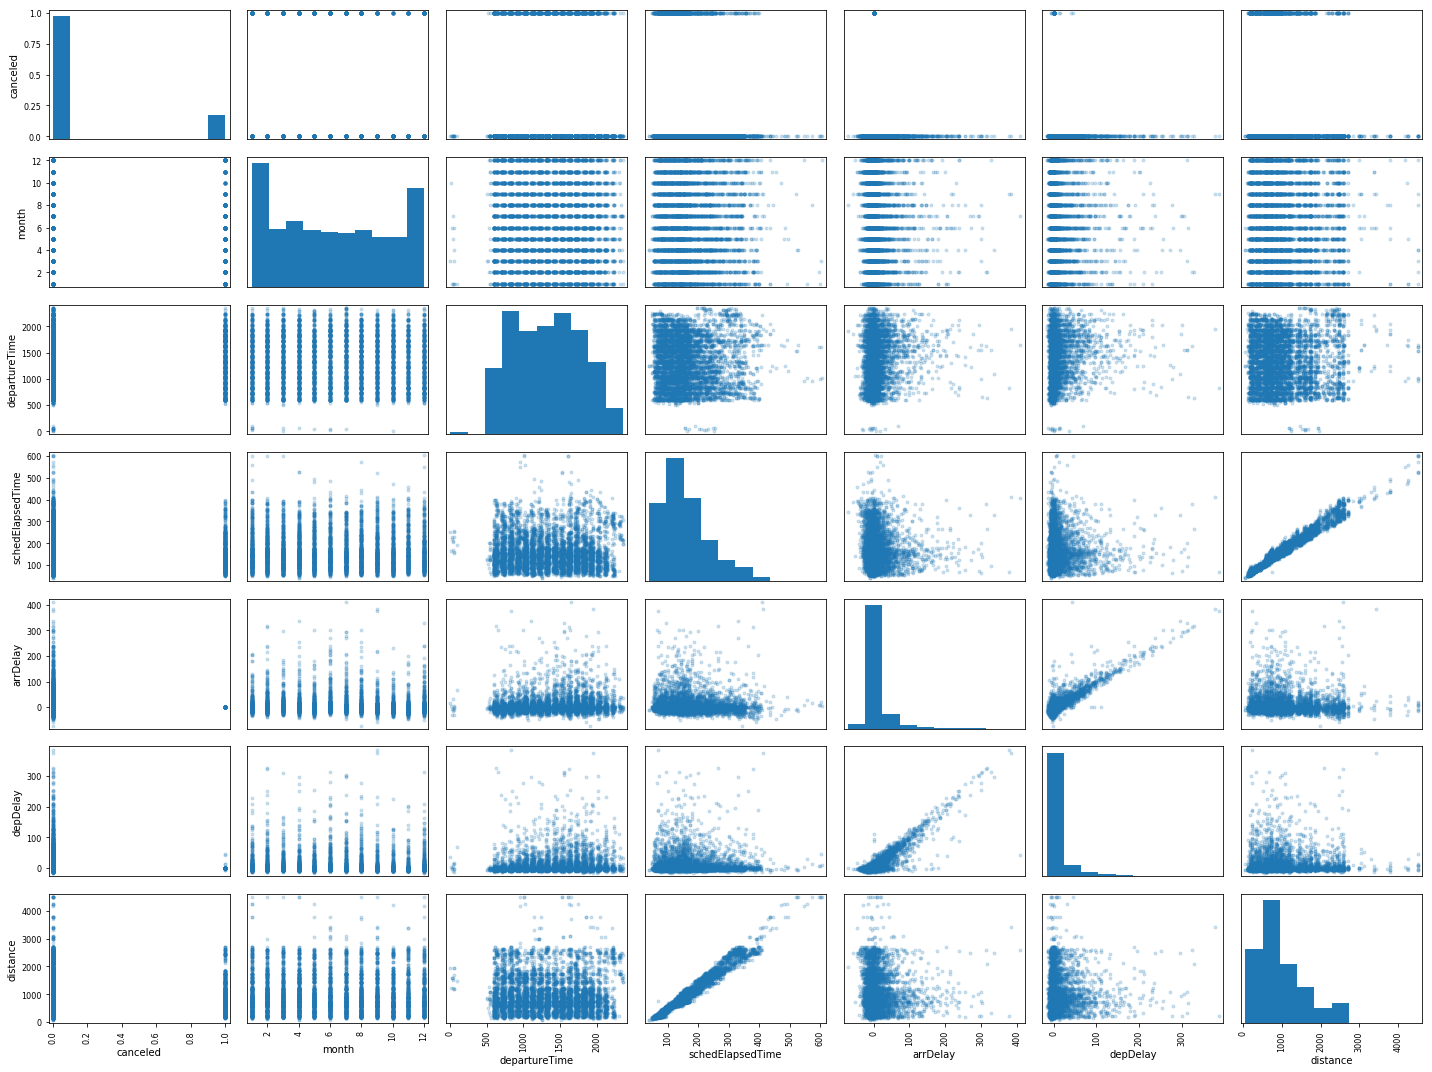

In [6]:
# Plot the pairwise connections between variables in the dataset
plt.rcParams["figure.figsize"] = (20,15)
axes = pd.tools.plotting.scatter_matrix(data, alpha=0.2)
plt.tight_layout()
# plt.savefig('pairwise.png')
plt.show()

In [653]:
np.round(np.corrcoef(data.iloc[:,1:].values.T), 2)

array([[ 1.  , -0.01, -0.02, -0.02, -0.02, -0.02,  0.05, -0.02],
       [-0.01,  1.  , -0.02,  0.11,  0.14, -0.02, -0.01,  0.01],
       [-0.02, -0.02,  1.  ,  0.01,  0.03,  0.98, -0.07,  0.05],
       [-0.02,  0.11,  0.01,  1.  ,  0.9 ,  0.01, -0.02, -0.01],
       [-0.02,  0.14,  0.03,  0.9 ,  1.  ,  0.03, -0.05,  0.03],
       [-0.02, -0.02,  0.98,  0.01,  0.03,  1.  , -0.09,  0.05],
       [ 0.05, -0.01, -0.07, -0.02, -0.05, -0.09,  1.  , -0.42],
       [-0.02,  0.01,  0.05, -0.01,  0.03,  0.05, -0.42,  1.  ]])

In [151]:
data[data.canceled == 1].arrDelay.value_counts()

0    1000
Name: arrDelay, dtype: int64

In [665]:
data[data.canceled == 1].depDelay.value_counts()

 0     990
-2       2
 46      1
 41      1
-4       1
 14      1
 13      1
-7       1
-6       1
 3       1
Name: depDelay, dtype: int64

In [152]:
data[data.arrDelay == 0].canceled.value_counts()

1    1000
0     165
Name: canceled, dtype: int64

In [666]:
data[data.depDelay == 0].canceled.value_counts()

1    990
0    309
Name: canceled, dtype: int64

In [774]:
# Scale the selected variables so as to decrease variance
data1 = data
data1.month = data1.apply(lambda a:a.month/float(10),axis=1)
data1.departureTime = data1.apply(lambda a:a.departureTime/float(1000),axis=1)
data1.schedElapsedTime = data1.apply(lambda a:a.schedElapsedTime/float(60),axis=1)
data1.distance = data1.apply(lambda a:a.distance/float(1000),axis=1)

In [12]:
data1.head(3)

,canceled,month,departureTime,schedElapsedTime,arrDelay,depDelay,distance,uniqueCarrier_DL,uniqueCarrier_UA
0,1,1.2,0.814,2.233333,0,0,0.679,0,1
1,1,1.2,0.830,1.500000,0,0,0.214,1,0
2,1,0.1,1.835,3.550000,0,0,1.605,0,1


In [148]:
data1.iloc[4000:4003,:]

,canceled,month,departureTime,schedElapsedTime,arrDelay,depDelay,distance,uniqueCarrier_DL,uniqueCarrier_UA
4000,0,0.9,1.946,2.100000,-6,-4,0.612,0,1
4001,0,1.1,1.221,6.033333,-26,-7,2.419,0,1
4002,0,0.7,1.925,1.166667,37,0,0.258,0,0


## Feature Selection 

In [285]:
X = data1.loc[:, ['month','departureTime','schedElapsedTime','distance','uniqueCarrier_DL','uniqueCarrier_UA']].values
y = data1.iloc[:, 0].values

In [286]:
from sklearn.feature_selection import chi2
scores, pValues = chi2(X,y)

In [287]:
scores

array([ 20.79281959,   0.14313506,  18.17398501,  17.68747044,
        36.36445498,   0.56470588])

In [288]:
pValues 

array([  5.11744697e-06,   7.05184014e-01,   2.01614113e-05,
         2.60335794e-05,   1.63660891e-09,   4.52370361e-01])

In [484]:
# Choose some sample data as using the whole original data to build a model can generate huge bias 
sample = pd.concat([data1[data1.canceled == 1],data1[data1.canceled == 0].sample(1200)])

In [661]:
X = sample.loc[:, ['month','schedElapsedTime','distance','uniqueCarrier_DL','uniqueCarrier_UA']].values
y = sample.iloc[:, 0].values

## Modeling

#### Logistic Regression

In [427]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

In [827]:
log_score = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)
    log = LogisticRegression()
    log.fit(X_train,y_train)
    log_score.append(log.score(X_test,y_test))
    print log.coef_ # compare coef between DL and UA
    print log.intercept_
log_score   

[[-0.9518773   0.88527266 -2.26150121 -0.84674538 -0.21448736]]
[ 0.46372669]
[[-0.96930564  0.91162963 -2.34979216 -0.84818541 -0.27640789]]
[ 0.47409079]
[[-0.85722111  0.85106373 -2.22518312 -0.89036133 -0.26671951]]
[ 0.50622888]
[[-0.86005708  0.91164945 -2.33939501 -0.83886244 -0.25518378]]
[ 0.43918583]
[[-0.99257586  0.82527617 -2.21732287 -0.81701835 -0.17448523]]
[ 0.56183313]
[[-0.93213907  0.99452753 -2.54387878 -0.73269073 -0.18545513]]
[ 0.37394127]
[[-0.91772801  0.99391478 -2.53222126 -0.88452287 -0.18428115]]
[ 0.36952063]
[[-0.99435385  0.9455568  -2.41676378 -0.86891114 -0.25536673]]
[ 0.45932631]
[[-0.95842358  0.91904515 -2.36271403 -0.75294621 -0.20710092]]
[ 0.43202193]
[[-0.86342002  0.93698943 -2.44303192 -0.80207233 -0.22987473]]
[ 0.42606041]


[0.65909090909090906,
 0.59999999999999998,
 0.65454545454545454,
 0.6454545454545455,
 0.63636363636363635,
 0.66363636363636369,
 0.55909090909090908,
 0.59545454545454546,
 0.59545454545454546,
 0.65909090909090906]

In [693]:
log_score_lable = ["{:.1%}".format(i) for i in log_score]

In [699]:
log_score_lable

['65.0%',
 '63.2%',
 '63.2%',
 '59.1%',
 '63.6%',
 '62.7%',
 '64.1%',
 '59.5%',
 '61.4%',
 '63.6%']

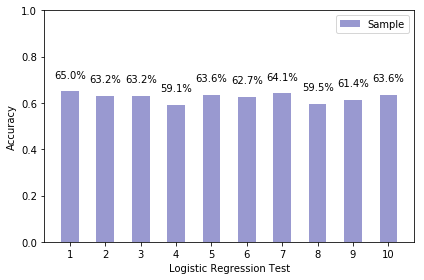

In [696]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
index = np.arange(10)
rects = plt.bar(index, log_score, 0.5, alpha=0.4,color='darkblue',label='Sample')
plt.xlabel('Logistic Regression Test')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xticks(index, range(1,11))
for rect, label in zip(ax.patches, [str(i) for i in log_score_lable]):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.05, label, ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

In [498]:
classification_report(y_test, log.predict(X_test))

'             precision    recall  f1-score   support\n\n          0       0.69      0.67      0.68       123\n          1       0.60      0.61      0.60        97\n\navg / total       0.65      0.65      0.65       220\n'

Logistic Regression CV

In [825]:
from sklearn.model_selection import GridSearchCV

In [662]:
log_param_grid = {"C": [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],"penalty": ['l1', 'l2']}
log_grid_search = GridSearchCV(LogisticRegression(), log_param_grid, cv=10)
log_grid_search.fit(X, y)
log_grid_search.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [663]:
log_grid_search.score(X,y)

0.63090909090909086

#### KNN

In [501]:
from sklearn.neighbors import KNeighborsClassifier
k_range = range(1,31)
k_score = []
from sklearn.cross_validation import cross_val_score
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv = 10, scoring = 'accuracy')
    k_score.append(score.mean())

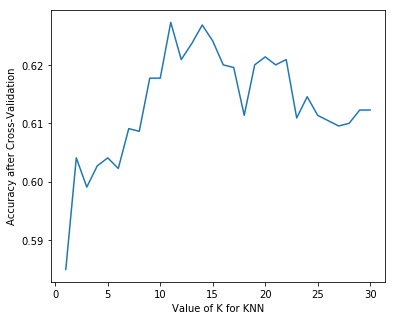

In [502]:
plt.rcParams["figure.figsize"] = (6,5)
plt.plot(k_range, k_score)
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy after Cross-Validation')
plt.show()

In [504]:
# From the plot above, I found the model has a comparably better performance when n = 11
knn_cv_score = cross_val_score(KNeighborsClassifier(n_neighbors=11), X, y, cv = 10, scoring = 'accuracy')
knn_cv_score.mean()

0.6272727272727272

#### LDA & QDA 

In [799]:
from sklearn.lda import LDA
from sklearn.qda import QDA

In [697]:
lda_cv = LDA()
lda_cv_score = cross_val_score(lda_cv, X, y, cv = 10, scoring = 'accuracy')
lda_cv_score

array([ 0.6       ,  0.65909091,  0.64090909,  0.60454545,  0.59545455,
        0.64090909,  0.57727273,  0.7       ,  0.61818182,  0.58636364])

In [698]:
lda_cv_score.mean()

0.6222727272727272

In [511]:
qda_cv = QDA()
qda_cv_score = cross_val_score(qda_cv, X, y, cv = 10, scoring = 'accuracy')
qda_cv_score

array([ 0.61363636,  0.62727273,  0.64090909,  0.58181818,  0.6       ,
        0.60454545,  0.61818182,  0.66818182,  0.61818182,  0.56363636])

In [512]:
qda_cv_score.mean()

0.61363636363636365

#### SVM

In [447]:
from sklearn.svm import SVC

In [380]:
def svc_param_selection(X, y, kernel, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [381]:
svc_param_selection(X,y,'rbf',10)

{'C': 10, 'gamma': 0.1}

In [513]:
svc_cv = SVC(C=10,gamma=0.1,kernel='rbf')
svc_cv_score = cross_val_score(svc_cv, X, y, cv = 10, scoring = 'accuracy')
svc_cv_score.mean()

0.63227272727272732

In [383]:
svc_param_selection(X,y,'linear',10)

{'C': 10, 'gamma': 0.001}

In [515]:
svc_cv = SVC(C=10,gamma=0.001,kernel='linear')
svc_cv_score = cross_val_score(svc_cv, X, y, cv = 10, scoring = 'accuracy')
svc_cv_score.mean()

0.62954545454545452

#### Random Forest

In [391]:
from sklearn.ensemble import RandomForestClassifier

In [710]:
param_grid = {"max_depth": [2, 3, None],
          "max_features": [2, 3, 5],
          "min_samples_split": [2, 3, 10],
          "min_samples_leaf": [1, 3, 10],
          "bootstrap": [True, False],
          "criterion": ["gini", "entropy"]}
grid_search = GridSearchCV(RandomForestClassifier(n_estimators=20), param_grid, cv=10)
grid_search.fit(X, y)
grid_search.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 2,
 'min_samples_leaf': 10,
 'min_samples_split': 3}

In [711]:
# The accuracy of the best model in this case
grid_search.score(X,y)

0.745

Obtain feature importance of each variable in the model

In [728]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [798]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [800]:
rf.feature_importances_

array([ 0.29587817,  0.2686059 ,  0.33166764,  0.07011757,  0.03373072])

Test on test dataset

In [718]:
grid_search.predict(X_test)

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0])

In [719]:
y_test

array([1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0])

In [720]:
# Calculate accuracy for the test data
from sklearn.metrics import accuracy_score
accuracy_score(y_test, grid_search.predict(X_test))

0.73636363636363633

Prediction Function

In [762]:
def flight_prediction(data,row_number):
    data.drop(data.columns[[5,6]], axis=1)
    data = pd.get_dummies(data,columns=[3],drop_first=True)
    row = data.iloc[row_number,:]
    Input = np.array([float(row[1])/10,float(row[2])/1000,float(row[7])/1000,float(row['3_DL']),float(row['3_UA'])])
    return grid_search.predict(Input).tolist()[0]

Test on a random selected row

In [767]:
test_data = data.head()
test_row = test_data.iloc[3,:]
test_row

0       1
1       4
2    1730
3      AA
4      80
5       0
6       0
7     235
Name: 3, dtype: object

In [768]:
flight_prediction(test_data,3)

/Users/feiyiwang/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


1

## Results

#### Selected Model

In [714]:
res_dict = {'LogReg':0.6309,'KNN':0.6273,'LDA':0.6223,'QDA':0.6136,'SVM RBF':0.6323,'SVM Linear':0.6295,'RanFor':0.7450}

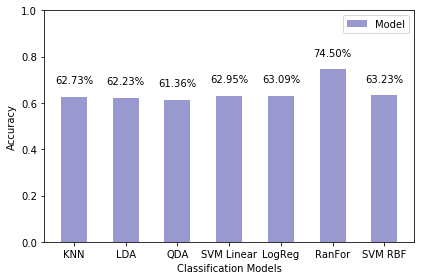

In [715]:
# Plot accuracy of all the implemented models
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
index = np.arange(len(res_dict))
rects = plt.bar(index, res_dict.values(), 0.5, alpha=0.4,color='darkblue',label='Model')
plt.xlabel('Classification Models')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xticks(index, res_dict.keys())
for rect, label in zip(ax.patches, ["{:.2%}".format(i) for i in res_dict.values()]):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.05, label, ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

#### Reliable Airline

In [782]:
cancel_dl = len(data[(data.canceled == 1)&(data.uniqueCarrier_DL == 1)])
cancel_ua = len(data[(data.canceled == 1)&(data.uniqueCarrier_UA == 1)])
cancel_aa = len(data[(data.canceled == 1)&(data.uniqueCarrier_DL == 0)&(data.uniqueCarrier_UA == 0)])

In [794]:
dl = len(data[data.uniqueCarrier_DL == 1])
ua = len(data[data.uniqueCarrier_UA == 1])
aa = len(data[(data.uniqueCarrier_DL == 0)&(data.uniqueCarrier_UA == 0)])

In [795]:
cancel = {'DL':cancel_dl,'UA':cancel_ua,'AA':cancel_aa}
cancel

{'AA': 493, 'DL': 189, 'UA': 318}

In [796]:
airline = {'DL':dl,'UA':ua,'AA':aa}
airline

{'AA': 2476, 'DL': 1688, 'UA': 1836}

In [821]:
x_ticks = [i + " - " + "{:.2%}".format(float(cancel[i])/float(airline[i])) for i in airline.keys()]

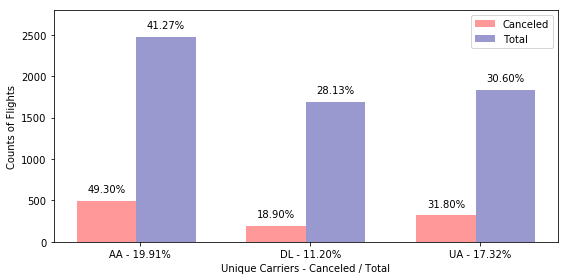

In [824]:
# Plot accuracy of all the implemented models
fig, ax = plt.subplots()
fig.set_size_inches(8,4)
index = np.arange(len(airline))
rects1 = plt.bar(index, cancel.values(), 0.35, alpha=0.4,color='r',label='Canceled')
rects2 = plt.bar(index+0.35, airline.values(), 0.35, alpha=0.4,color='darkblue',label='Total')
plt.xlabel('Unique Carriers - Canceled / Total')
plt.ylabel('Counts of Flights')
plt.ylim([0,2800])
plt.xticks(index+0.2, x_ticks)
for rect, label in zip(ax.patches[:3], ["{:.2%}".format(float(i)/1000) for i in cancel.values()]):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 80, label, ha='center', va='bottom')
for rect, label in zip(ax.patches[3:], ["{:.2%}".format(float(i)/6000) for i in airline.values()]):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 80, label, ha='center', va='bottom')
# for rect, label in zip(ax.patches[3:], ["{:.2%}".format(float(cancel[i])/float(airline[i])) for i in airline.keys()]):
#     height = rect.get_height()
#     ax.text(rect.get_x(), 40, label, ha='center', va='bottom',color='w')
plt.legend()
plt.tight_layout()
plt.show()

In [791]:
pValues[-2] # DL

1.6366089066946617e-09

In [793]:
pValues[-1] # UA

0.45237036067736092

In [814]:
rf.feature_importances_[-2] # DL

0.070117570696452788

In [815]:
rf.feature_importances_[-1] # UA

0.033730721456543253